In [5]:
import re
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import string
import nltk
import warnings 
warnings.filterwarnings("ignore", category=DeprecationWarning)

from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers import GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from keras.preprocessing.text import Tokenizer

%matplotlib inline

Using TensorFlow backend.


# Define train data

In [6]:
train=pd.read_csv("/Users/apple/Documents/Train.csv")
train = train[['TweetText', 'Sentiment', 'Topic']]
train = train[train.Sentiment != 'irrelevant']
train.head()

,TweetText,Sentiment,Topic
0,Now all @Apple has to do is get swype on the i...,positive,apple
1,@Apple will be adding more carrier support to ...,positive,apple
2,Hilarious @youtube video - guy does a duet wit...,positive,apple
3,@RIM you made it too easy for me to switch to ...,positive,apple
4,I just realized that the reason I got into twi...,positive,apple


In [7]:
X_train=train['TweetText']

# Define test data

In [8]:
test=pd.read_csv("/Users/apple/Documents/Test.csv")
test = test[['TweetText', 'Sentiment', 'Topic']]
test = test[test.Sentiment != 'irrelevant']
test.head()

,TweetText,Sentiment,Topic
0,RT @JamaicanIdler: Lmao I think @apple is onto...,positive,apple
1,"Bravo, @Apple! http://t.co/BgoTzj7K",positive,apple
2,"Day305, I'm thankful for the great customer se...",positive,apple
3,i love this. so much. thank you @apple. http:...,positive,apple
4,I &lt;3 @apple http://t.co/ondXWpEr,positive,apple


In [9]:
X_test=test['TweetText']

# Clean data

In [10]:
def remove_pattern(input_txt, pattern):
    r= re.findall(pattern, input_txt)
    for i in r:
        input_txt=re.sub(i,'',input_txt)
        
    return input_txt

In [11]:
train['tidy_tweet']=np.vectorize(remove_pattern)(train['TweetText'], "@[\w]*")
train['tidy_tweet']=train['tidy_tweet'].str.replace("[^a-z,A-z#]"," ")
train['tidy_tweet']=train['tidy_tweet'].apply(lambda x:' '.join([w for w in x.split() if len(w)>3]))
train.head()

,TweetText,Sentiment,Topic,tidy_tweet
0,Now all @Apple has to do is get swype on the i...,positive,apple,swype iphone will crack Iphone that
1,@Apple will be adding more carrier support to ...,positive,apple,will adding more carrier support iPhone just a...
2,Hilarious @youtube video - guy does a duet wit...,positive,apple,Hilarious video does duet with Siri Pretty muc...
3,@RIM you made it too easy for me to switch to ...,positive,apple,made easy switch iPhone
4,I just realized that the reason I got into twi...,positive,apple,just realized that reason into twitter thanks


In [12]:
test['tidy_tweet']=np.vectorize(remove_pattern)(test['TweetText'], "@[\w]*")
test['tidy_tweet']=test['tidy_tweet'].str.replace("[^a-z,A-z#]"," ")
test['tidy_tweet']=test['tidy_tweet'].apply(lambda x:' '.join([w for w in x.split() if len(w)>3]))
test.head()

,TweetText,Sentiment,Topic,tidy_tweet
0,RT @JamaicanIdler: Lmao I think @apple is onto...,positive,apple,Lmao think onto something magical DYING haha S...
1,"Bravo, @Apple! http://t.co/BgoTzj7K",positive,apple,"Bravo, http BgoTzj"
2,"Day305, I'm thankful for the great customer se...",positive,apple,thankful great customer service received today...
3,i love this. so much. thank you @apple. http:...,positive,apple,love this much thank http lOEzX
4,I &lt;3 @apple http://t.co/ondXWpEr,positive,apple,http ondXWpEr


# Tokenizer

In [13]:
tokenized_tweet = train['tidy_tweet'].apply(lambda x: x.split())
tokenized_tweet.head()

0           [swype, iphone, will, crack, Iphone, that]
1    [will, adding, more, carrier, support, iPhone,...
2    [Hilarious, video, does, duet, with, Siri, Pre...
3                         [made, easy, switch, iPhone]
4    [just, realized, that, reason, into, twitter, ...
Name: tidy_tweet, dtype: object

In [14]:
tokenized_tweet = test['tidy_tweet'].apply(lambda x: x.split())
tokenized_tweet.head()

0    [Lmao, think, onto, something, magical, DYING,...
1                               [Bravo,, http, BgoTzj]
2    [thankful, great, customer, service, received,...
3               [love, this, much, thank, http, lOEzX]
4                                     [http, ondXWpEr]
Name: tidy_tweet, dtype: object

In [15]:
from nltk.stem.porter import *
stemmer=PorterStemmer()
tokenized_tweet=tokenized_tweet.apply(lambda x:[stemmer.stem(i) for i in x])
tokenized_tweet.head()

0    [lmao, think, onto, someth, magic, dy, haha, s...
1                               [bravo,, http, bgotzj]
2    [thank, great, custom, servic, receiv, today, ...
3                [love, thi, much, thank, http, loezx]
4                                     [http, ondxwper]
Name: tidy_tweet, dtype: object

# Wordcloud to explain train data

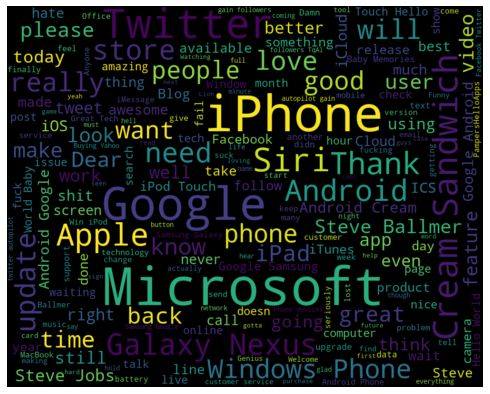

In [17]:
train_words=' '.join([text for text in train['tidy_tweet']])
from wordcloud import WordCloud
wordcloud=WordCloud(width=1000, height=800, random_state=21, max_font_size=110).generate(train_words)
plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

# Wordcloud to explain test data

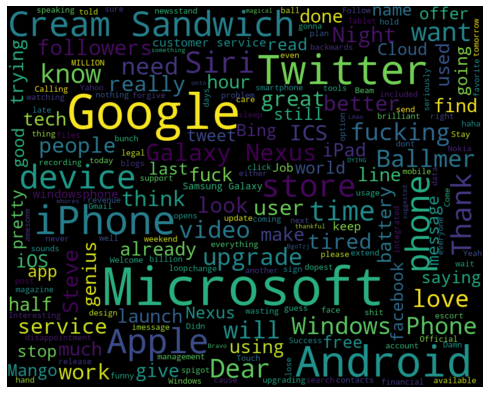

In [18]:
test_words=' '.join([text for text in test['tidy_tweet']])
from wordcloud import WordCloud
wordcloud=WordCloud(width=1000, height=800, random_state=21, max_font_size=110).generate(test_words)
plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

# Show the hashtag trends in train

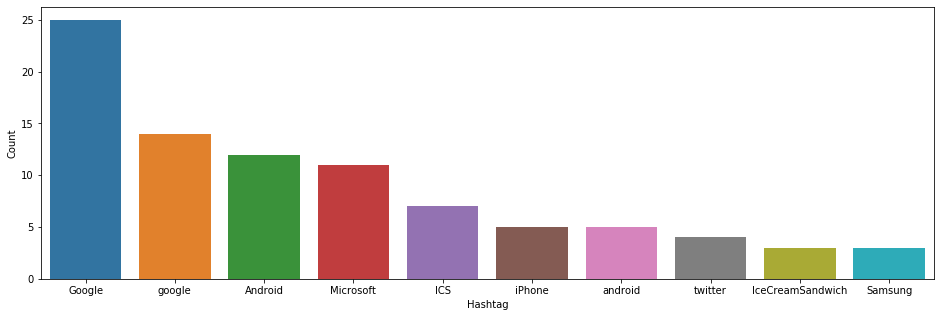

In [19]:
def hashtag_extract(x):
    hashtags=[]
    for i in x:
        ht=re.findall(r"#(\w+)",i)
        hashtags.append(ht)
    return hashtags

train_positive=hashtag_extract(train['tidy_tweet'][train['Sentiment']== 'positive'])
train_negative=hashtag_extract(train['tidy_tweet'][train['Sentiment']=='negative'])
train_neutral=hashtag_extract(train['tidy_tweet'][train['Sentiment']=='neutral'])

train_positive_sum=sum(train_positive,[])
train_negative_sum=sum(train_negative,[])
train_neutral_sum=sum(train_neutral,[])

a=nltk.FreqDist(train_positive_sum)
d=pd.DataFrame({'Hashtag': list(a.keys()), 'Count':list(a.values())})
d=d.nlargest(columns="Count",n=10)
plt.figure(figsize=(16,5))
ax=sns.barplot(data=d, x= "Hashtag", y= "Count")
plt.show()

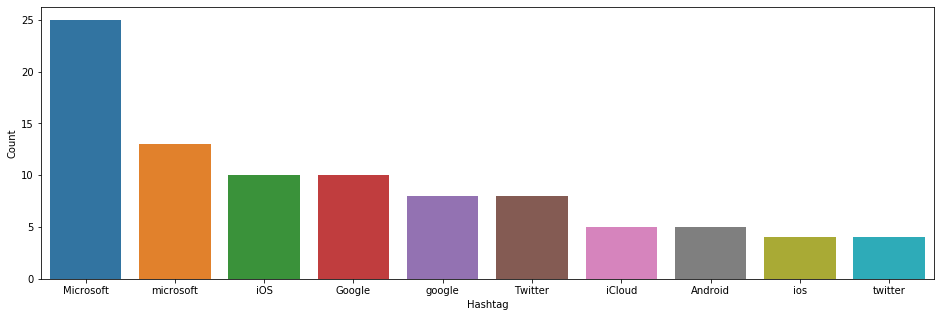

In [20]:
b=nltk.FreqDist(train_negative_sum)
e=pd.DataFrame({'Hashtag':list(b.keys()),'Count':list(b.values())})
e=e.nlargest(columns="Count",n=10)
plt.figure(figsize=(16,5))
ax=sns.barplot(data=e, x="Hashtag", y="Count")
plt.show()

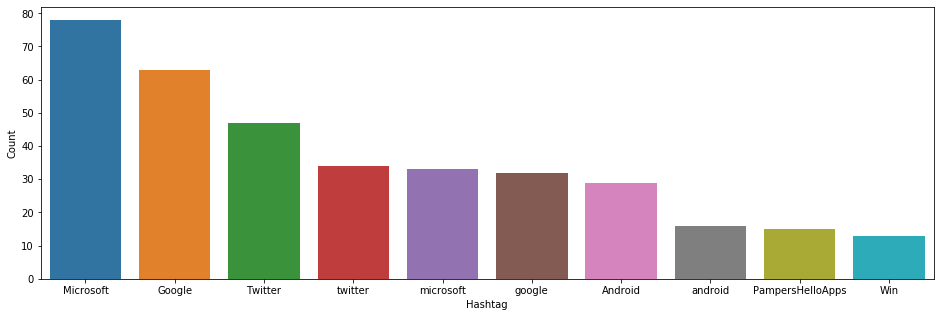

In [21]:
g=nltk.FreqDist(train_neutral_sum)
h=pd.DataFrame({'Hashtag':list(g.keys()),'Count':list(g.values())})
h=h.nlargest(columns="Count",n=10)
plt.figure(figsize=(16,5))
ax=sns.barplot(data=h, x="Hashtag", y="Count")
plt.show()

# Vectorizer

In [22]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer=CountVectorizer(max_df=0.90, min_df=2, stop_words='english', max_features=1000)
xtrain_vec=vectorizer.fit_transform(train['tidy_tweet'])
xtest_vec=vectorizer.transform(test['tidy_tweet'])

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer=TfidfVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
tfidf_train=tfidf_vectorizer.fit_transform(train['tidy_tweet'])
tfidf_test=tfidf_vectorizer.transform(test['tidy_tweet'])

# Get scores

In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
ytrain = train['Sentiment']
ytest = test['Sentiment']
ztrain = train['Topic']
ztest = test['Topic']
#init logistic regression
egg_sen=LogisticRegression(multi_class='auto', solver='lbfgs')
egg_sen.fit(xtrain_vec, ytrain)
egg_pred=egg_sen.predict(xtest_vec)
print(accuracy_score(egg_pred,ytest))

0.7510548523206751


In [25]:
egg_top=LogisticRegression(multi_class='auto', solver='lbfgs')
egg_top.fit(xtrain_vec, ztrain)
egg_pred_1=egg_top.predict(xtest_vec)
print(accuracy_score(egg_pred_1,ztest))

0.759493670886076


In [26]:
from sklearn.naive_bayes import MultinomialNB 
ham_sen=MultinomialNB()
ham_sen.fit(xtrain_vec, ytrain)
ham_pre=ham_sen.predict(xtest_vec)
print(accuracy_score(ham_pre, ytest))

0.7341772151898734


In [27]:
ham_top=MultinomialNB()
ham_top.fit(xtrain_vec, ztrain)
ham_pre_1=ham_top.predict(xtest_vec)
print(accuracy_score(ham_pre_1, ztest))

0.7046413502109705


In [28]:
from sklearn.metrics import classification_report
print(classification_report(egg_pred, ytest))

              precision    recall  f1-score   support

    negative       0.41      0.74      0.53        27
     neutral       0.93      0.76      0.84       190
    positive       0.41      0.65      0.50        20

    accuracy                           0.75       237
   macro avg       0.58      0.72      0.62       237
weighted avg       0.83      0.75      0.77       237



In [29]:
pd.DataFrame({'Topic':test['Topic'], 'NB_topic': ham_pre_1}).head()

,Topic,NB_topic
0,apple,apple
1,apple,apple
2,apple,apple
3,apple,apple
4,apple,apple


# Predict

In [ ]:
new=input('File Link')
new1=pd.read_csv(new)
NS=new1['Sentiment']
NTO=new1['Topic']

new1['tidytweet'] = np.vectorize(remove_pattern)(new1['TweetText'], "@[\w]*")
new1['tidytweet'] = new1['tidytweet'].str.replace("[^a-z,A-z#]"," ")
new1['tidytweet'] = new1['tidytweet'].apply(lambda x:' '.join([w for w in x.split() if len(w)>3]))
N_vec = vectorizer.transform(new1['tidytweet'])
sen_new = egg_sen.predict(N_vec)
top_new = egg_top.predict(N_vec)
sen_new1 = ham_sen.predict(N_vec)
top_new1 = ham_top.predict(N_vec)

In [ ]:
n= pd.DataFrame({'TweetText': new1['TweetText'], 'Sentiment': new1['Sentiment'], 'Log_Sentiment': sen_new, 'NB_Sentiment': sen_new1, 'Topic': new1['Topic'], 'Log_Topic': top_new, 'NB_Topic': top_new1})
n[0:15]